In [72]:
import torch

### Computational graph

Here we have a 1-layer neural network and its corresponding computational graph:

In [73]:
x = torch.ones(5) # input tensor
y = torch.zeros(3)  # expected output

w = torch.randn(5, 3, requires_grad = True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w) + b # y_hat

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

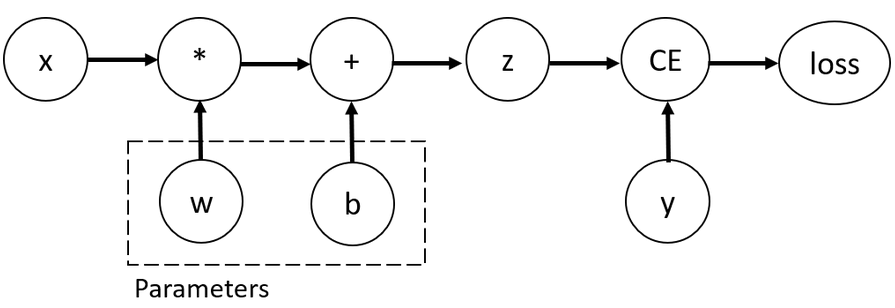

`w` and `b` are parameters which we need to optimize, so we indicate that `requires_grad=True`.

We can obtain a reference to the backward propagation function given a tensor:

In [74]:
print('Gradient function for z = ', z.grad_fn)
print('Gradient function for loss = ', loss.grad_fn)

Gradient function for z =  <AddBackward0 object at 0x7f6f0cbaa530>
Gradient function for loss =  <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f6f0cbabcd0>


### Computing gradients

We need to compute the derivatives of the loss function with respecto to parameters:

> d(loss)/d(w)

> d(loss)/d(b)

To compute those derivatives, we call `loss.backward()`:

In [75]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.2827, 0.2983, 0.2544],
        [0.2827, 0.2983, 0.2544],
        [0.2827, 0.2983, 0.2544],
        [0.2827, 0.2983, 0.2544],
        [0.2827, 0.2983, 0.2544]])
tensor([0.2827, 0.2983, 0.2544])


`w.grad` and `b.grad` are those derivatives.

- We can only obtain the `grad` properties for the leaf nodes of the computational graph, which have `requires_grad` property to be `True`.

- We can only perform gradient calculations using `backward` once on a given graph. If we need to do several `backward` calls, we need to pass `retain_graph=True`.

Note how PyTorch accumulates gradients when using `retain_graph`. We can make them zero in the following way:

In [76]:
x = torch.ones(5)
y = torch.zeros(3) 

w = torch.randn(5, 3, requires_grad = True)
b = torch.randn(3, requires_grad = True)
z = torch.matmul(x, w) + b

loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

loss.backward(retain_graph=True)
print('w gradients after backward 1: ', w.grad)

loss.backward(retain_graph=True)
print('w gradients after backward 2: ', w.grad)

w.grad.zero_()
print('w gradients after grad.zero: ', w.grad)


w gradients after backward 1:  tensor([[0.2685, 0.1457, 0.0356],
        [0.2685, 0.1457, 0.0356],
        [0.2685, 0.1457, 0.0356],
        [0.2685, 0.1457, 0.0356],
        [0.2685, 0.1457, 0.0356]])
w gradients after backward 2:  tensor([[0.5369, 0.2914, 0.0712],
        [0.5369, 0.2914, 0.0712],
        [0.5369, 0.2914, 0.0712],
        [0.5369, 0.2914, 0.0712],
        [0.5369, 0.2914, 0.0712]])
w gradients after grad.zero:  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


### Disabling gradient tracking

By default, all tensors with `requires_grad=True` support gradient computation and are tracked.

Reasons to disable gradient tracking:

- Frozen parameters.
- Speed up computations when we are only doing forward pass (computations on tensors that do not track gradients would be more efficient).

If we only want the model to be applied to some input data, we can stop tracking computations by using `torch.no_grad()`:

In [77]:
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


We can achieve the same result by using `detach()`:

In [78]:
z = torch.matmul(x, w) + b
z_det = z.detach()
print(z_det.requires_grad)

False


### More on computational graphs

Autograd keeps a record of data (tensors) and all executed operations.

- Leaves are input tensors.
- Roots are output tensors.

By tracing this graph from roots to leaves, you can automatically compute gradients using the _chain rule_.

In a forward pass, autograd:

1. runs the requested operation to compute a resulting tensor
2. maintains the operation's gradient function in the graph

When `.backward()` is called on the graph root, the backward pass kicks off. `autograd` then:

1. computes de gradients from each `.grad_fn`
2. accumulates them in the respective tensor's `.grad` attribute
3. using the chain rule, propagates all the way to the leaf tensors

The graph is recreated from scratch after each `.backward()` call.